In [1]:
require(data.table)
require(ggplot2)
require(TSrepr)
require(TSdist)
require(dtw)
require(Rcpp)

Loading required package: data.table

Warning message:
"package 'data.table' was built under R version 4.0.5"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.0.5"
Loading required package: TSrepr

Warning message:
"package 'TSrepr' was built under R version 4.0.5"
Loading required package: TSdist

Warning message:
"package 'TSdist' was built under R version 4.0.5"
Loading required package: proxy

Warning message:
"package 'proxy' was built under R version 4.0.5"

Attaching package: 'proxy'


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loaded TSdist v3.7. See ?TSdist for help, citation("TSdist") for use in publication.


Loading required package: dtw

Warning message:
"package 'dtw' was built under R version 4.0.5"
Loaded dtw v1.22-3. See ?

In [2]:
# assuming you have the data folder in your working directory in the following format:
# 'working_directory/ClassificationData/dataset_name/'
current_folder=getwd()
dataset='ECG200'
main_path=sprintf('%s/ClassificationData/%s/%s',current_folder,dataset,dataset)

dist_path=sprintf('%s/ClassificationData/%s/distances/%s',current_folder,dataset,dataset)

train_data_path=sprintf('%s_TRAIN.txt',main_path)
traindata=as.matrix(fread(train_data_path))
traindata_rep = fread(train_data_path) ## for representations, class data needs to be hold.

test_data_path=sprintf('%s_TEST.txt',main_path)
testdata=as.matrix(fread(test_data_path))
testdata_rep = fread(test_data_path)
#first column is the class variable
trainclass=traindata[,1] # takes -1 and 1
testclass=testdata[,1] # takes -1 and 1

#drop first column
traindata=traindata[,2:ncol(traindata)]
testdata=testdata[,2:ncol(testdata)]

# instance characteristics
tlength=ncol(traindata)
n_series_train=nrow(traindata)
n_series_test=nrow(testdata)

In [3]:
##### K = 1  
## raw + euclidian
## raw + DTW
## raw + LCSS 
## raw + ERP 
##### K = 3 
## raw + euclidian 
## raw + DTW 
## raw + LCSS 
## raw + ERP 
##### K = 5
## raw + euclidian
## raw + DTW
## raw + LCSS 
## raw + ERP

### Representations

Prepare data as long format for representations 

In [4]:
setnames(traindata_rep,'V1','class')

traindata_rep <- traindata_rep[order(class)]

head(traindata_rep)

traindata_rep[,class:=as.character(class)]
traindata_rep[,id:=1:.N]
long_train=melt(traindata_rep,id.vars=c('id','class'))

long_train[,time:=as.numeric(gsub("\\D", "", variable))-1]

long_train=long_train[,list(id,class,time,value)]
long_train=long_train[order(id,time)]

long_train

class,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1,0.5020555,0.5421626,0.7223835,1.428885,2.136516,2.281149,1.9362737,1.4688900,1.0088451,...,0.9310429,0.6102984,0.6388943,0.68467857,0.58323764,0.6405217,0.70858515,0.7050109,0.7138155,0.43376464
-1,0.3166462,0.2431991,0.3704714,1.063738,1.678187,1.759558,1.6977172,1.6121590,1.1681877,...,0.7642290,0.6106215,0.5529003,0.56678608,0.60400236,0.7770678,0.81234542,0.7488481,0.8180420,0.53934704
-1,1.1688741,2.0759008,1.7601405,1.606446,1.949046,1.302842,0.4593315,0.5164121,0.8521795,...,0.4190064,0.7238876,1.3239469,2.13648760,1.74659650,1.4702205,1.89351230,1.2569493,0.8004066,0.73153981
-1,1.2050062,2.0318554,2.4472937,2.739448,2.745890,2.276355,1.5253659,0.7605966,0.1884477,...,0.4473114,0.5646415,0.4876003,0.42100331,0.54976604,0.5054632,0.28184434,0.3468314,0.5263752,0.22788969
-1,0.5982414,1.0987288,1.6835287,2.478913,2.802413,2.438696,1.7176569,1.0093086,0.2573508,...,0.3946300,0.5257822,0.2793480,-0.06965778,0.02754396,0.1530247,0.04223191,0.1342688,0.2961504,0.06293182
-1,0.5011230,0.7291306,0.8337402,1.255770,2.001362,2.504033,2.4541953,2.2203273,2.1224353,...,0.3580163,0.6058888,0.7109627,0.61971023,0.56493009,0.5561137,0.56181896,0.6581866,0.6397110,0.24261796


id,class,time,value
<int>,<chr>,<dbl>,<dbl>
1,-1,1,0.5020555
1,-1,2,0.5421626
1,-1,3,0.7223835
1,-1,4,1.4288852
1,-1,5,2.1365158
1,-1,6,2.2811490
1,-1,7,1.9362737
1,-1,8,1.4688900
1,-1,9,1.0088451


#### Piecewise Aggregate Approximation

##### Segment Length = 5

In [5]:
# Piecewise Aggregate Approximation
segment_length=5

# sort long table just in case
long_train=long_train[order(id,time)]

paa_results <- vector('list',n_series_train)
for (i in 1:n_series_train){

data_ts=long_train[id==i]$value
paa_rep=repr_paa(data_ts, segment_length, meanC)
#plot(paa_rep,type='l')
paa_results[[i]] <- paa_rep 
}
paa_list <- vector('list', n_series_train)
for (i in 1:n_series_train) {
  
    paa_list[[i]] = as.data.table(t(paa_results[[i]]))
  
    }
paa_fit_5 <- rbindlist(paa_list) 
paa_fit_5


V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.0664005,1.4150880,-0.292276426,-0.37067881,-0.96365775,-1.1896584,-1.65953844,-1.7888610,-1.404272320,-0.577380768,0.13643486,0.58372124,0.684339202,0.6229568800,0.64411163,0.69980885,0.84572670,0.79074897,0.670234158,0.43376464
0.7344484,1.3475157,-0.153993400,-0.42961784,-0.93881920,-1.3082628,-1.75885322,-1.9269195,-1.363652180,-0.337281056,0.32196252,0.68991191,0.800696124,0.7770153740,0.67333863,0.75944011,0.59991297,0.65322697,0.752061154,0.53934704
1.7120814,0.8239985,0.660243824,-0.15212011,-0.27344018,-1.0023200,-1.52961124,-1.7795765,-1.640022100,-0.955914366,-0.06767240,0.41106286,0.387761134,0.2933554000,0.23656453,0.19631658,0.14150006,0.95794753,1.433537036,0.73153981
2.2338986,0.9443428,-0.195458492,-0.42124600,-0.82207352,-0.7241534,-1.23554351,-1.6382904,-1.549690560,-1.004007748,-0.03714381,0.36886054,0.592103526,0.5175129820,0.61235629,0.50073797,0.87490115,0.49525959,0.442056040,0.22788969
1.7323650,1.0402908,-0.179893567,-0.45779342,-0.95844906,-1.6062455,-2.04214934,-1.5367931,-0.366375201,0.283219291,0.50667806,0.49815402,0.512139152,0.6717357240,0.64245900,0.53922686,0.27644202,0.30175900,0.130643970,0.06293182
1.0642252,2.2435029,0.469702746,0.07343792,-0.05705454,-0.4606550,-0.85814454,-1.3046479,-1.759571740,-1.604598260,-1.10320086,-0.28283313,0.126789762,0.4657377400,0.51938152,0.75825224,0.53542770,0.52957247,0.596152062,0.24261796
1.3525324,0.4377745,-1.080506526,-1.32241978,-1.37576882,-1.5223872,-1.49133692,-0.8639619,0.004814393,0.232882916,0.29471448,0.31296058,0.419967546,0.7162223980,0.58009288,0.50830750,0.28437017,0.52007317,1.911847540,0.39910334
1.5967393,1.2868979,-0.176284918,-0.35549803,-0.72572670,-1.1293185,-1.65427412,-1.7950910,-1.422060320,-0.557836590,0.07421097,0.28131800,0.367790060,0.4454868260,0.54552559,0.59026213,0.98298325,0.74009521,0.805770700,0.49505124
1.5957610,0.4899013,-1.421414860,-1.86172642,-1.83859078,-0.8628715,1.05827345,1.4445106,0.818399444,0.434580280,0.24830180,0.04891636,0.010747925,-0.0575610696,-0.01487426,0.12110170,0.13395609,-0.21804864,-0.132549044,0.01593298


#### Fused Lasso

In [6]:
require(genlasso)
lasso_results <- vector("list",n_series_train)

for(i in 1:n_series_train){
  selected_dt <- long_train[id == i]
  selected_dt <- as.matrix(selected_dt[,4], rownames=FALSE)
  flasso <- trendfilter(selected_dt, ord=0)
  cv <- cv.trendfilter(flasso)
     
    #print(paste0(i,'.Time Series' ))
    #print(paste0('minimum crossvalidated error:',cv$lambda.min))
    #print(paste0('1se error:',cv$lambda.min))
  lasso_results[[i]] <- predict.genlasso(flasso, cv$lambda.min)
  
}


Loading required package: genlasso

Warning message:
"package 'genlasso' was built under R version 4.0.5"
Loading required package: Matrix

Loading required package: igraph

Warning message:
"package 'igraph' was built under R version 4.0.5"

Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold

In [7]:
lasso_dt = vector('list', n_series_train)
for(i in seq(1:n_series_train)){
lasso_dt[[i]] =as.data.table(t(lasso_results[[i]]$fit))
}
lasso_fit_dt = rbindlist(lasso_dt)
head(lasso_fit_dt)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5029490,0.5421626,0.7223835,1.428885,2.136516,2.279362,1.9362737,1.4688900,1.0088451,0.38028224,...,0.9310429,0.6120855,0.6388943,0.68289144,0.58502477,0.6405217,0.70679802,0.7067980,0.7120283,0.43465821
0.3138179,0.2488557,0.3704714,1.063738,1.678187,1.753901,1.6977172,1.6121590,1.1681877,0.49995704,...,0.7642290,0.6106215,0.5585569,0.56678608,0.60400236,0.7770678,0.80668883,0.7545047,0.8123854,0.54217534
1.1695894,2.0744703,1.7601405,1.607876,1.947615,1.302842,0.4607621,0.5164121,0.8521795,0.98779663,...,0.4190064,0.7238876,1.3239469,2.13505706,1.74659650,1.4716510,1.89208176,1.2569493,0.8004066,0.73225508
1.2068665,2.0318554,2.4472937,2.739448,2.742169,2.276355,1.5253659,0.7605966,0.1884477,-0.02905146,...,0.4510319,0.5609210,0.4876003,0.42472382,0.54604553,0.5054632,0.28556485,0.3468314,0.5226547,0.22974995
0.6009172,1.0987288,1.6835287,2.478913,2.797061,2.438696,1.7176569,1.0093086,0.2573508,-0.21620681,...,0.3946300,0.5204305,0.2793480,-0.06430606,0.02754396,0.1476730,0.04758363,0.1342688,0.2907987,0.06560768
0.5034890,0.7291306,0.8337402,1.255770,2.001362,2.499301,2.4541953,2.2203273,2.1224353,1.91652360,...,0.3580163,0.6058888,0.7062307,0.61971023,0.56493009,0.5608456,0.56181896,0.6534547,0.6397110,0.24498393


### Classification Trees

#### Max Depth 5

In [8]:
library(caret)
library(rpart)
predictions= vector('list', n_series_train)
for(j in 1:n_series_train){
   
selected_dt <- long_train[id == j]

ctrl1=trainControl(method='repeatedcv',number=10,repeats=5)
fit_tree=train(value~time, 
                   data= selected_dt,
                   method = "rpart",
                   control = rpart.control(minsplit = 20, minbucket = 10, maxdepth = 5),
                   metric = 'RMSE',
                   trControl = ctrl1,
                   tuneGrid = expand.grid(cp = 0), 
    )
    
predictions[[j]] <- predict(fit_tree,selected_dt)

}
prediction_list = vector('list', n_series_train)
for(i in seq(1:n_series_train)){
prediction_list[[i]] = as.data.table(t(predictions[[i]]))
}

tree_fit_dt_5 = rbindlist(prediction_list)
tree_fit_dt_5

Warning message:
"package 'caret' was built under R version 4.0.5"
Loading required package: lattice



1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.2407443,1.2407443,1.2407443,1.2407443,1.2407443,1.2407443,1.2407443,1.2407443,1.2407443,1.2407443,...,0.66498496,0.66498496,0.66498496,0.66498496,0.66498496,0.66498496,0.66498496,0.66498496,0.66498496,0.66498496
0.7116314,0.7116314,0.7116314,0.7116314,0.7116314,0.7116314,0.7116314,0.7116314,0.7116314,0.7116314,...,0.69127896,0.69127896,0.69127896,0.69127896,0.69127896,0.69127896,0.69127896,0.69127896,0.69127896,0.69127896
1.1195829,1.1195829,1.1195829,1.1195829,1.1195829,1.1195829,1.1195829,1.1195829,1.1195829,1.1195829,...,1.25025535,1.25025535,1.25025535,1.25025535,1.25025535,1.25025535,1.25025535,1.25025535,1.25025535,1.25025535
1.5891207,1.5891207,1.5891207,1.5891207,1.5891207,1.5891207,1.5891207,1.5891207,1.5891207,1.5891207,...,0.43587263,0.43587263,0.43587263,0.43587263,0.43587263,0.43587263,0.43587263,0.43587263,0.43587263,0.43587263
1.3863279,1.3863279,1.3863279,1.3863279,1.3863279,1.3863279,1.3863279,1.3863279,1.3863279,1.3863279,...,0.21337758,0.21337758,0.21337758,0.21337758,0.21337758,0.21337758,0.21337758,0.21337758,0.21337758,0.21337758
1.5546853,1.5546853,1.5546853,1.5546853,1.5546853,1.5546853,1.5546853,1.5546853,1.5546853,1.5546853,...,0.52591670,0.52591670,0.52591670,0.52591670,0.52591670,0.52591670,0.52591670,0.52591670,0.52591670,0.52591670
0.8951535,0.8951535,0.8951535,0.8951535,0.8951535,0.8951535,0.8951535,0.8951535,0.8951535,0.8951535,...,1.24288625,1.24288625,1.24288625,1.24288625,1.24288625,1.24288625,1.24288625,1.24288625,1.24288625,1.24288625
1.4418186,1.4418186,1.4418186,1.4418186,1.4418186,1.4418186,1.4418186,1.4418186,1.4418186,1.4418186,...,0.79866238,0.79866238,0.79866238,0.79866238,0.79866238,0.79866238,0.79866238,0.79866238,0.79866238,0.79866238
1.0428311,1.0428311,1.0428311,1.0428311,1.0428311,1.0428311,1.0428311,1.0428311,1.0428311,1.0428311,...,-0.16131172,-0.16131172,-0.16131172,-0.16131172,-0.16131172,-0.16131172,-0.16131172,-0.16131172,-0.16131172,-0.16131172


#### Max Depth 7

In [9]:
library(caret)
library(rpart)
predictions= vector('list', n_series_train)
for(j in 1:n_series_train){
   
selected_dt <- long_train[id == j]

ctrl1=trainControl(method='repeatedcv',number=10,repeats=5)
fit_tree=train(value~time, 
                   data= selected_dt,
                   method = "rpart",
                   control = rpart.control(minsplit = 20, minbucket = 10, maxdepth = 7),
                   metric = 'RMSE',
                   trControl = ctrl1,
                   tuneGrid = expand.grid(cp = 0), 
    )
    
predictions[[j]] <- predict(fit_tree,selected_dt)

}
prediction_list = vector('list', n_series_train)
for(i in seq(1:n_series_train)){
prediction_list[[i]] = as.data.table(t(predictions[[i]]))
}

tree_fit_dt_7 = rbindlist(prediction_list)
tree_fit_dt_7

1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.2407443,1.2407443,1.2407443,1.2407443,1.2407443,1.2407443,1.2407443,1.2407443,1.2407443,1.2407443,...,0.66498496,0.66498496,0.66498496,0.66498496,0.66498496,0.66498496,0.66498496,0.66498496,0.66498496,0.66498496
0.7116314,0.7116314,0.7116314,0.7116314,0.7116314,0.7116314,0.7116314,0.7116314,0.7116314,0.7116314,...,0.69127896,0.69127896,0.69127896,0.69127896,0.69127896,0.69127896,0.69127896,0.69127896,0.69127896,0.69127896
1.1195829,1.1195829,1.1195829,1.1195829,1.1195829,1.1195829,1.1195829,1.1195829,1.1195829,1.1195829,...,1.25025535,1.25025535,1.25025535,1.25025535,1.25025535,1.25025535,1.25025535,1.25025535,1.25025535,1.25025535
1.5891207,1.5891207,1.5891207,1.5891207,1.5891207,1.5891207,1.5891207,1.5891207,1.5891207,1.5891207,...,0.43587263,0.43587263,0.43587263,0.43587263,0.43587263,0.43587263,0.43587263,0.43587263,0.43587263,0.43587263
1.3863279,1.3863279,1.3863279,1.3863279,1.3863279,1.3863279,1.3863279,1.3863279,1.3863279,1.3863279,...,0.21337758,0.21337758,0.21337758,0.21337758,0.21337758,0.21337758,0.21337758,0.21337758,0.21337758,0.21337758
1.5546853,1.5546853,1.5546853,1.5546853,1.5546853,1.5546853,1.5546853,1.5546853,1.5546853,1.5546853,...,0.52591670,0.52591670,0.52591670,0.52591670,0.52591670,0.52591670,0.52591670,0.52591670,0.52591670,0.52591670
0.8951535,0.8951535,0.8951535,0.8951535,0.8951535,0.8951535,0.8951535,0.8951535,0.8951535,0.8951535,...,1.24288625,1.24288625,1.24288625,1.24288625,1.24288625,1.24288625,1.24288625,1.24288625,1.24288625,1.24288625
1.4418186,1.4418186,1.4418186,1.4418186,1.4418186,1.4418186,1.4418186,1.4418186,1.4418186,1.4418186,...,0.79866238,0.79866238,0.79866238,0.79866238,0.79866238,0.79866238,0.79866238,0.79866238,0.79866238,0.79866238
1.0428311,1.0428311,1.0428311,1.0428311,1.0428311,1.0428311,1.0428311,1.0428311,1.0428311,1.0428311,...,-0.16131172,-0.16131172,-0.16131172,-0.16131172,-0.16131172,-0.16131172,-0.16131172,-0.16131172,-0.16131172,-0.16131172


## Distance Calculations

#### Euclidian

In [10]:
large_number=100000

In [11]:
# raw + euclidian
dist_euc=as.matrix(dist(traindata))
diag(dist_euc)=large_number
fwrite(dist_euc,sprintf('%s_euc_raw_dist.csv',dist_path),col.names=F)


x being coerced from class: matrix to data.table



In [12]:
# fusedlasso + euclidian
dist_euc_lasso=as.matrix(dist(lasso_fit_dt))
diag(dist_euc_lasso)=large_number
fwrite(dist_euc_lasso,sprintf('%s_euc_raw_lasso_dist.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table



In [13]:
# tree( max depth = 5) + euclidian
dist_euc_tree5=as.matrix(dist(tree_fit_dt_5))
diag(dist_euc_tree5)=large_number
fwrite(dist_euc_tree5,sprintf('%s_euc_raw_tree_depth_5_dist.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table



In [14]:
# tree( max depth = 7) + euclidian
dist_euc_tree7=as.matrix(dist(tree_fit_dt_7))
diag(dist_euc_tree7)=large_number
fwrite(dist_euc_tree7,sprintf('%s_euc_raw_tree_depth_7_dist.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table



In [15]:
# PAA( segment length = 5) + euclidian
dist_euc_paa=as.matrix(dist(paa_fit_5))
diag(dist_euc_paa)=large_number
fwrite(dist_euc_paa,sprintf('%s_euc_raw_paa_segment_5_dist.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table



#### Dynamic Time Warping

In [16]:
# DTW
dist_dtw=as.matrix(dtwDist(traindata))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s_dtw_raw_dist.csv',dist_path),col.names=F)


x being coerced from class: matrix to data.table



In [17]:
# fusedlasso + DTW
dist_dtw_lasso=as.matrix(dtwDist(lasso_fit_dt))
diag(dist_dtw_lasso)=large_number
fwrite(dist_dtw_lasso,sprintf('%s_dtw_raw_lasso_dist.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table



In [18]:
# tree ( max depth = 5) + DTW
dist_dtw_tree5=as.matrix(dtwDist(tree_fit_dt_5))
diag(dist_dtw_tree5)=large_number
fwrite(dist_dtw_tree5,sprintf('%s_dtw_raw_tree_depth_5_dist.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table



In [19]:
# tree ( max depth = 7) + DTW
dist_dtw_tree7=as.matrix(dtwDist(tree_fit_dt_7))
diag(dist_dtw_tree7)=large_number
fwrite(dist_dtw_tree7,sprintf('%s_dtw_raw_tree_depth_7_dist.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table



In [20]:
# PAA( segment length = 5) + DTW
dist_dtw_paa=as.matrix(dtwDist(paa_fit_5))
diag(dist_dtw_paa)=large_number
fwrite(dist_dtw_paa,sprintf('%s_dtw_raw_paa_segment_5_dist.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table



#### LCSS

In [21]:
# LCSS
dist_lcss=TSDatabaseDistances(traindata,distance='lcss',epsilon=0.05)
dist_lcss=as.matrix(dist_lcss)
diag(dist_lcss)=large_number
fwrite(dist_lcss,sprintf('%s_lcss_raw_epsilon_005.csv',dist_path),col.names=F)


x being coerced from class: matrix to data.table



In [22]:
# fusedlasso + LCSS
dist_lcss_lasso=TSDatabaseDistances(lasso_fit_dt,distance='lcss',epsilon=0.05)
dist_lcss_lasso=as.matrix(dist_lcss_lasso)
diag(dist_lcss_lasso)=large_number
fwrite(dist_lcss_lasso,sprintf('%s_lcss_raw_lasso_epsilon_005.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table



In [23]:
# tree ( max depth = 5) + LCSS
dist_lcss_tree5=TSDatabaseDistances(tree_fit_dt_5,distance='lcss',epsilon=0.05)
dist_lcss_tree5=as.matrix(dist_lcss_tree5)
diag(dist_lcss_tree5)=large_number
fwrite(dist_lcss_tree5,sprintf('%s_lcss_raw_tree_depth_5_epsilon_005.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table



In [24]:
# tree ( max depth = 7) + LCSS
dist_lcss_tree7=TSDatabaseDistances(tree_fit_dt_7,distance='lcss',epsilon=0.05)
dist_lcss_tree7=as.matrix(dist_lcss_tree7)
diag(dist_lcss_tree7)=large_number
fwrite(dist_lcss_tree7,sprintf('%s_lcss_raw_tree_depth_7_epsilon_005.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table



In [25]:
# PAA( segment length = 5) + LCSS
dist_lcss_paa=TSDatabaseDistances(paa_fit_5,distance='lcss',epsilon=0.05)
dist_lcss_paa=as.matrix(dist_lcss_paa)
diag(dist_lcss_paa)=large_number
fwrite(dist_lcss_paa,sprintf('%s_lcss_raw_paa_segment_5_epsilon_005.csv',dist_path),col.names=F)

x being coerced from class: matrix to data.table



#### ERP

In [26]:
# ERP 
dist_erp=TSDatabaseDistances(traindata,distance='erp',g=0.5)
dist_erp=as.matrix(dist_erp)
diag(dist_erp)=large_number
fwrite(dist_erp,sprintf('%s_erp_raw_gap_005.csv',dist_path),col.names=F)  

x being coerced from class: matrix to data.table



In [27]:
# Fusedlasso + ERP 
dist_erp_lasso=TSDatabaseDistances(lasso_fit_dt,distance='erp',g=0.5)
dist_erp_lasso=as.matrix(dist_erp_lasso)
diag(dist_erp_lasso)=large_number
fwrite(dist_erp_lasso,sprintf('%s_erp_raw_lasso_gap_005.csv',dist_path),col.names=F)  

x being coerced from class: matrix to data.table



In [28]:
# tree ( max depth = 5) + ERP 
dist_erp_tree5=TSDatabaseDistances(tree_fit_dt_5,distance='erp',g=0.5)
dist_erp_tree5=as.matrix(dist_erp_tree5)
diag(dist_erp_tree5)=large_number
fwrite(dist_erp_tree5,sprintf('%s_erp_raw_tree_dist_5_gap_005.csv',dist_path),col.names=F)  

x being coerced from class: matrix to data.table



In [29]:
# tree ( max depth = 7) + ERP 
dist_erp_tree7=TSDatabaseDistances(tree_fit_dt_7,distance='erp',g=0.5)
dist_erp_tree7=as.matrix(dist_erp_tree7)
diag(dist_erp_tree7)=large_number
fwrite(dist_erp_tree7,sprintf('%s_erp_raw_tree_dist_7_gap_005.csv',dist_path),col.names=F)  

x being coerced from class: matrix to data.table



In [30]:
# PAA( segment length = 5) + ERP 
dist_erp_paa=TSDatabaseDistances(paa_fit_5,distance='erp',g=0.5)
dist_erp_paa=as.matrix(dist_erp_paa)
diag(dist_erp_paa)=large_number
fwrite(dist_erp_paa,sprintf('%s_erp_raw_paa_segment_5_gap_005.csv',dist_path),col.names=F)  

x being coerced from class: matrix to data.table



In [31]:
nn_classify_cv=function(dist_matrix,train_class,test_indices,k=1){
    
    test_distances_to_train=dist_matrix[test_indices,]
    test_distances_to_train=test_distances_to_train[,-test_indices]
    train_class=train_class[-test_indices]
    #print(str(test_distances_to_train))
    ordered_indices=apply(test_distances_to_train,1,order)
    if(k==1){
        nearest_class=as.numeric(trainclass[as.numeric(ordered_indices[1,])])
        nearest_class=data.table(id=test_indices,nearest_class)
    } else {
        nearest_class=apply(ordered_indices[1:k,],2,function(x) {trainclass[x]})
        nearest_class=data.table(id=test_indices,t(nearest_class))
    }
    
    long_nn_class=melt(nearest_class,'id')

    class_counts=long_nn_class[,.N,list(id,value)]
    class_counts[,predicted_prob:=N/k]
    wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
    wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
    class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]
    
    
    return(list(prediction=class_predictions,prob_estimates=wide_class_prob_predictions))
    
}

In [32]:
# cv indices start here
require(TunePareto)

set.seed(15011998)
nof_rep=5
n_fold=10
cv_indices=generateCVRuns(trainclass, ntimes =nof_rep, nfold = n_fold, 
                          leaveOneOut = FALSE, stratified = TRUE)

str(cv_indices)

dist_folder=sprintf('%s/ClassificationData/%s/distances/',current_folder,dataset)
dist_files=list.files(dist_folder, full.names=T)

Loading required package: TunePareto

Warning message:
"package 'TunePareto' was built under R version 4.0.5"


List of 5
 $ Run  1:List of 10
  ..$ Fold  1 : int [1:10] 1 54 19 91 9 92 16 49 78 37
  ..$ Fold  2 : int [1:10] 28 3 8 70 51 23 39 79 61 67
  ..$ Fold  3 : int [1:10] 7 20 66 80 77 82 18 65 10 63
  ..$ Fold  4 : int [1:10] 45 36 86 30 13 88 11 5 2 29
  ..$ Fold  5 : int [1:10] 44 57 47 75 74 76 26 43 22 21
  ..$ Fold  6 : int [1:10] 15 4 48 83 53 32 6 96 31 35
  ..$ Fold  7 : int [1:10] 73 58 94 90 68 42 12 100 14 33
  ..$ Fold  8 : int [1:10] 97 89 24 25 93 38 56 55 95 17
  ..$ Fold  9 : int [1:10] 50 84 87 71 41 27 34 81 99 72
  ..$ Fold  10: int [1:10] 85 98 62 59 60 64 69 46 52 40
 $ Run  2:List of 10
  ..$ Fold  1 : int [1:10] 84 50 24 91 42 53 56 13 29 23
  ..$ Fold  2 : int [1:10] 48 54 3 75 55 78 21 99 64 93
  ..$ Fold  3 : int [1:10] 19 86 8 83 27 100 63 14 61 39
  ..$ Fold  4 : int [1:10] 89 98 47 17 51 68 5 6 92 88
  ..$ Fold  5 : int [1:10] 4 1 28 33 2 18 70 79 12 22
  ..$ Fold  6 : int [1:10] 15 85 20 49 11 81 31 96 32 76
  ..$ Fold  7 : int [1:10] 36 7 66 10 9 82 65 34 3

In [33]:
list.files(dist_folder)

[1] "ECG200_dtw_raw_dist.csv"                      
 [2] "ECG200_dtw_raw_lasso_dist.csv"                
 [3] "ECG200_dtw_raw_paa_segment_5_dist.csv"        
 [4] "ECG200_dtw_raw_tree_depth_5_dist.csv"         
 [5] "ECG200_dtw_raw_tree_depth_7_dist.csv"         
 [6] "ECG200_erp_raw_gap_005.csv"                   
 [7] "ECG200_erp_raw_lasso_gap_005.csv"             
 [8] "ECG200_erp_raw_paa_segment_5_gap_005.csv"     
 [9] "ECG200_erp_raw_tree_dist_5_gap_005.csv"       
[10] "ECG200_erp_raw_tree_dist_7_gap_005.csv"       
[11] "ECG200_euc_raw_dist.csv"                      
[12] "ECG200_euc_raw_lasso_dist.csv"                
[13] "ECG200_euc_raw_paa_segment_5_dist.csv"        
[14] "ECG200_euc_raw_tree_depth_5_dist.csv"         
[15] "ECG200_euc_raw_tree_depth_7_dist.csv"         
[16] "ECG200_lcss_raw_epsilon_005.csv"              
[17] "ECG200_lcss_raw_lasso_epsilon_005.csv"        
[18] "ECG200_lcss_raw_paa_segment_5_epsilon_005.csv"
[19] "ECG200_lcss_raw_tree_depth_5_epsilon_005.csv" 
[20] "ECG200_lcss_raw_tree_depth_7_epsilon_005.csv"

In [34]:
dist_files

[1] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_dtw_raw_dist.csv"                      
 [2] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_dtw_raw_lasso_dist.csv"                
 [3] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_dtw_raw_paa_segment_5_dist.csv"        
 [4] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_dtw_raw_tree_depth_5_dist.csv"         
 [5] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_dtw_raw_tree_depth_7_dist.csv"         
 [6] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_erp_raw_gap_005.csv"                   
 [7] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_erp_raw_lasso_gap_005.csv"             
 [8] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_erp_raw_paa_segment_5_gap_005.csv"     
 [9] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_erp_raw_tree_dist_5_gap_005.csv"       
[10] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_erp_raw_tree_dist_7_gap_005.csv"       
[11] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_euc_raw_dist.csv"                      
[12] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_euc_raw_lasso_dist.csv"                
[13] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_euc_raw_paa_segment_5_dist.csv"        
[14] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_euc_raw_tree_depth_5_dist.csv"         
[15] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_euc_raw_tree_depth_7_dist.csv"         
[16] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_lcss_raw_epsilon_005.csv"              
[17] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_lcss_raw_lasso_epsilon_005.csv"        
[18] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_lcss_raw_paa_segment_5_epsilon_005.csv"
[19] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_lcss_raw_tree_depth_5_epsilon_005.csv" 
[20] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_lcss_raw_tree_depth_7_epsilon_005.csv"

In [35]:
k_levels=c(1,3,5)
approach_file=list.files(dist_folder)
result=vector('list',length(dist_files)*nof_rep*n_fold*length(k_levels))
iter=1
for(m in 1:length(dist_files)){ #
    print(dist_files[m])
    dist_mat=as.matrix(fread(dist_files[m],header=FALSE))
    for(i in 1:nof_rep){
        this_fold=cv_indices[[i]]
        for(j in 1:n_fold){
            test_indices=this_fold[[j]]
            for(k in 1:length(k_levels)){
                current_k=k_levels[k]
                current_fold=nn_classify_cv(dist_mat,trainclass,test_indices,k=current_k)
                accuracy=sum(trainclass[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                tmp=data.table(approach=approach_file[m],repid=i,foldid=j,
                               k=current_k,acc=accuracy)
                result[[iter]]=tmp
                iter=iter+1
                
            }
            
        }
    
    }   
    
}


[1] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_dtw_raw_dist.csv"
[1] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_dtw_raw_lasso_dist.csv"
[1] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_dtw_raw_paa_segment_5_dist.csv"
[1] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_dtw_raw_tree_depth_5_dist.csv"
[1] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_dtw_raw_tree_depth_7_dist.csv"
[1] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_erp_raw_gap_005.csv"
[1] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_erp_raw_lasso_gap_005.csv"
[1] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/ClassificationData/ECG200/distances/ECG200_erp_raw_paa_segment_5_gap_005.csv"
[1] "C:/Users/brkmb/Desktop/kitaplar/IE48B/HW3/Classification

In [36]:
overall_results=rbindlist(result)
overall_results[,list(avg_acc=mean(acc),sdev_acc=sd(acc),result_count=.N),by=list(approach,k)]



approach,k,avg_acc,sdev_acc,result_count
<chr>,<dbl>,<dbl>,<dbl>,<int>
ECG200_dtw_raw_dist.csv,1,0.608,0.14405214,50
ECG200_dtw_raw_dist.csv,3,0.616,0.14478697,50
ECG200_dtw_raw_dist.csv,5,0.648,0.13588711,50
ECG200_dtw_raw_lasso_dist.csv,1,0.586,0.13402711,50
ECG200_dtw_raw_lasso_dist.csv,3,0.576,0.14365492,50
ECG200_dtw_raw_lasso_dist.csv,5,0.642,0.12631351,50
ECG200_dtw_raw_paa_segment_5_dist.csv,1,0.594,0.14625948,50
ECG200_dtw_raw_paa_segment_5_dist.csv,3,0.644,0.12148738,50
ECG200_dtw_raw_paa_segment_5_dist.csv,5,0.648,0.11292042,50


In [37]:
overall_results_summary <- overall_results[,list(avg_acc=mean(acc),sdev_acc=sd(acc),result_count=.N),by=list(approach,k)]


overall_results_summary[which.max(overall_results_summary$avg_acc),]

approach,k,avg_acc,sdev_acc,result_count
<chr>,<dbl>,<dbl>,<dbl>,<int>
ECG200_euc_raw_lasso_dist.csv,5,0.676,0.09160697,50


In [42]:
result_path <- sprintf('%s/overall_summary/%s',current_folder,dataset)
fwrite(overall_results_summary,sprintf('%s_overall_result_summary.csv',result_path),col.names=T)  

Loading required package: overall_resultsplot2

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'overall_resultsplot2'"


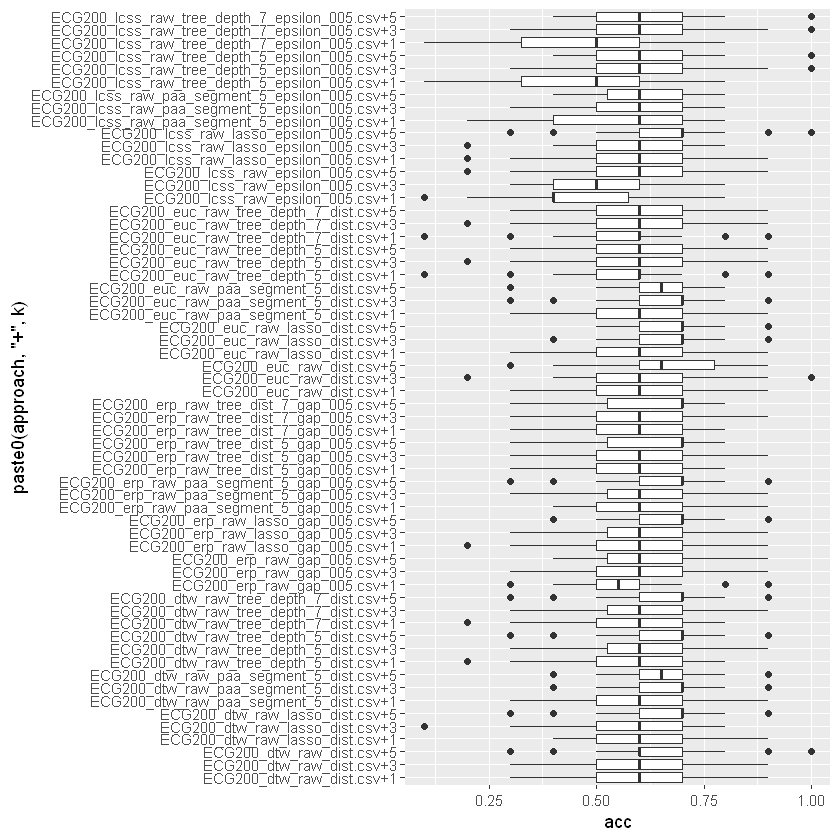

In [39]:
require(overall_resultsplot2)
ggplot(overall_results,aes(x=paste0(approach,'+',k), y=acc)) +
geom_boxplot()+
coord_flip()